# Merge & Align NASA + Oxford Battery Datasets
This notebook loads processed NASA and Oxford battery datasets, aligns their features, merges them, and visualizes combined degradation curves.

In [15]:
# --- 1. Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
print("Libraries loaded.")

Libraries loaded.


In [16]:
# --- 2. Load Processed Datasets ---
df_nasa = pd.read_csv('../data/processed/nasa_battery_degradation.csv')
df_oxford = pd.read_csv('../data/processed/oxford_battery_degradation.csv')

# Add dataset identifier
df_nasa['dataset'] = 'NASA'
df_oxford['dataset'] = 'Oxford'

print("Loaded datasets:")
print(f"NASA: {len(df_nasa)} rows")
print(f"Oxford: {len(df_oxford)} rows")

Loaded datasets:
NASA: 2794 rows
Oxford: 2076 rows


In [17]:
# --- 3. Inspect Column Names ---
print("\nNASA columns:")
print(df_nasa.columns.tolist())

print("\nOxford columns:")
print(df_oxford.columns.tolist())


NASA columns:
['battery_id', 'cycle_index', 'capacity', 'voltage', 'current', 'temperature', 'time', 'norm_capacity', 'RUL', 'dataset']

Oxford columns:
['battery_id', 'cycle_index', 'capacity', 'voltage', 'current', 'temperature', 'time', 'norm_capacity', 'RUL', 'dataset']


In [18]:
print(df_oxford.head())

  battery_id  cycle_index  capacity   voltage   current  temperature   time  \
0      Cell1            1  0.739111  3.819664       NaN    40.049519   3600   
1      Cell1            2  0.739111  3.735076 -0.739111    40.419340   3600   
2      Cell1            3  0.739111  3.793972       NaN    39.877812  64800   
3      Cell1            4  0.739820  3.769730 -0.041101    39.901900  64800   
4      Cell1            5  0.739820  3.821715       NaN    39.993983   3600   

   norm_capacity  RUL dataset  
0       0.999042  311  Oxford  
1       0.999042  310  Oxford  
2       0.999042  309  Oxford  
3       1.000000  308  Oxford  
4       1.000000  307  Oxford  


In [19]:
df_nasa.columns.tolist()

['battery_id',
 'cycle_index',
 'capacity',
 'voltage',
 'current',
 'temperature',
 'time',
 'norm_capacity',
 'RUL',
 'dataset']

In [20]:
# --- 4. Standardize Column Names ---
# Rename Oxford columns to match NASA format
df_oxford.rename(columns={
    'Cycle_Index': 'cycle_index',
    'Capacity_Ah': 'capacity',
    'Battery_ID': 'battery_id'
}, inplace=True)

# Select only relevant columns
print("Columns aligned.")

Columns aligned.


In [21]:
# --- 5. Combine Datasets ---
df_combined = pd.concat([df_nasa, df_oxford], ignore_index=True)
print(f"Merged dataset size: {len(df_combined)} rows")

Merged dataset size: 4870 rows


In [22]:
def normalize_capacity(group):
    # Use the first valid capacity as the initial capacity
    initial_capacity = group['capacity'].dropna().iloc[0]
    group['norm_capacity'] = group['capacity'] / initial_capacity
    return group

df_nasa = df_nasa.groupby('battery_id', group_keys=False).apply(normalize_capacity)
df_oxford = df_oxford.groupby('battery_id', group_keys=False).apply(normalize_capacity)

C:\Users\mufas\AppData\Local\Temp\ipykernel_7676\3238034069.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_nasa = df_nasa.groupby('battery_id', group_keys=False).apply(normalize_capacity)
C:\Users\mufas\AppData\Local\Temp\ipykernel_7676\3238034069.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_oxford = df_oxford.groupby('battery_id', group_keys=False).apply(normalize_capacity)


In [23]:
df_nasa = df_nasa[df_nasa['norm_capacity'].between(0, 1.5)].copy()  # Adjust bounds as needed
df_oxford = df_oxford[df_oxford['norm_capacity'].between(0, 1.5)].copy()

In [24]:
df_nasa['norm_capacity'].describe()

count    1966.000000
mean        0.859741
std         0.316848
min         0.000000
25%         0.745356
50%         0.884810
75%         0.996061
max         1.499589
Name: norm_capacity, dtype: float64

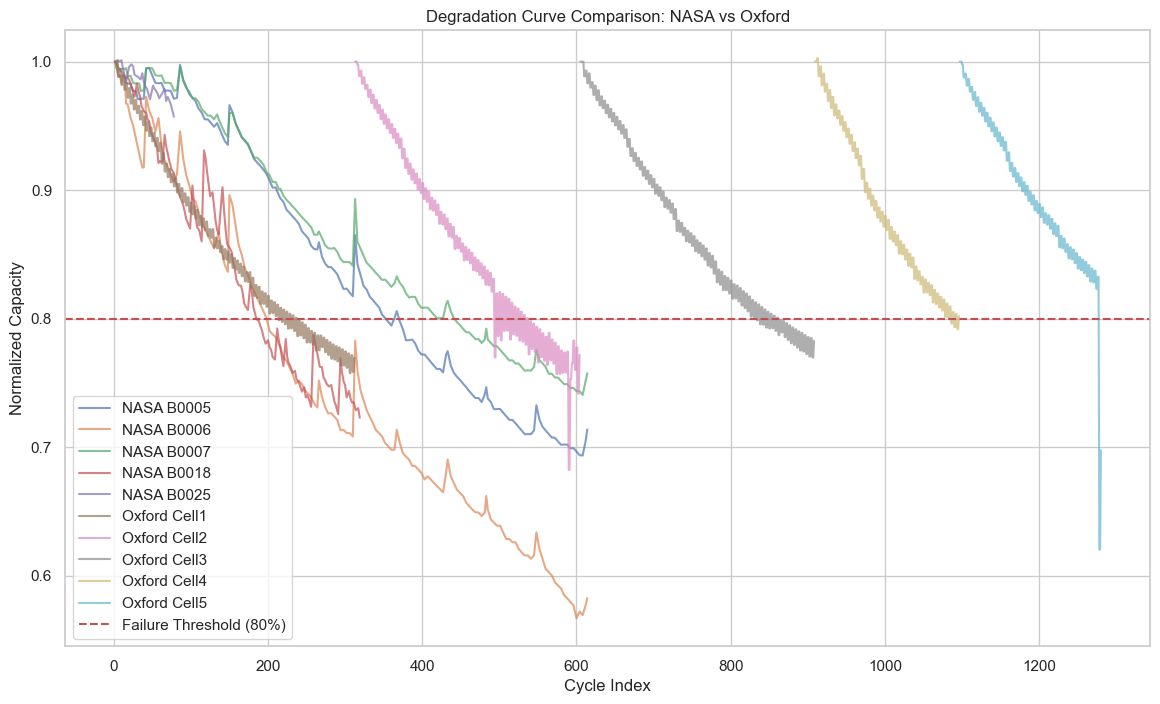

In [25]:
nasa_batteries_to_plot = df_nasa['battery_id'].unique()[:5]
oxford_batteries_to_plot = df_oxford['battery_id'].unique()[:5]

plt.figure(figsize=(14, 8))
for bat_id in nasa_batteries_to_plot:
    subset = df_nasa[df_nasa['battery_id'] == bat_id]
    plt.plot(subset['cycle_index'], subset['norm_capacity'], label=f'NASA {bat_id}', alpha=0.7)

for bat_id in oxford_batteries_to_plot:
    subset = df_oxford[df_oxford['battery_id'] == bat_id]
    plt.plot(subset['cycle_index'], subset['norm_capacity'], label=f'Oxford {bat_id}', alpha=0.7)

plt.axhline(y=0.8, color='r', linestyle='--', label='Failure Threshold (80%)')
plt.xlabel('Cycle Index')
plt.ylabel('Normalized Capacity')
plt.title('Degradation Curve Comparison: NASA vs Oxford')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# --- 7. Save Merged Dataset ---
output_path = '../data/processed/merged_battery_degradation.csv'
df_combined.to_csv(output_path, index=False)
print(f"Merged dataset saved to {output_path}")

Merged dataset saved to ../data/processed/merged_battery_degradation.csv
